# Assignment 2

In [1]:
import torch
torch.cuda.empty_cache()
import torchvision
from torchvision import datasets, transforms, models 
from torchvision.transforms import InterpolationMode
from torchvision.models import resnet18, mobilenet_v2, MobileNet_V2_Weights
from transformers import DistilBertModel, DistilBertTokenizer, AdamW, AutoProcessor, get_scheduler, AutoModelForCausalLM, AutoTokenizer
from torch.utils.data import DataLoader, Dataset 

import sys
sys.path.append('/home/poz/Notebooks/645_Assignment2')
# from customScript import customScript

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import ImageOps, Image
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns

import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

import re
import os
os.environ['CUDA_LAUNCH_BLOCKING']="1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32
print('CUDA available', torch.cuda.is_available())
print('CUDA version', torch.version.cuda)
print('cuDNN enabled', torch.backends.cudnn.enabled)
print('cuDNN version', torch.backends.cudnn.version())
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)

n_cuda_devices = torch.cuda.device_count()
for i in range(n_cuda_devices):
  print(f'Device {i} name:', torch.cuda.get_device_name(i))

batch_size = 32
image_resize = 224
num_workers = 4
num_epochs = 10
max_len = 24
best_loss = 1e+10
learning_rate = 2e-5
stats = (torch.tensor([0.4482, 0.4192, 0.3900]), torch.tensor([0.2918, 0.2796, 0.2709]))

CUDA available True
CUDA version 12.4
cuDNN enabled True
cuDNN version 90100
Device 0 name: NVIDIA GeForce RTX 2080 Ti


In [2]:
# Function to get thge statistics of a dataset
def get_dataset_stats(data_loader):
    mean = torch.zeros(3)
    std = torch.zeros(3)
    nb_samples = 0.
    for data in data_loader:
        data = data[0] # Get the images to compute the statistics
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples
    mean /= nb_samples
    std /= nb_samples
    return mean,std

# Modify the imshow function to ensure stats are on the same device as the image
def imshow(img, stats):
    mean = stats[0].view(3, 1, 1).to(img.device)  # Move mean to the same device as img
    std = stats[1].view(3, 1, 1).to(img.device)   # Move std to the same device as img
    img = img * std + mean
    npimg = img.cpu().numpy()  # Convert the tensor back to numpy after moving it to CPU
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Test function
def test_model(model, dataloader):
    model.load_state_dict(torch.load("best_model.pth"))
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

In [3]:
transform = {
    "train": transforms.Compose([
        transforms.Resize((232, 232), interpolation=InterpolationMode.BILINEAR),
        transforms.RandomCrop(image_resize),
        transforms.Resize((image_resize, image_resize)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    "val": transforms.Compose([
        transforms.Resize((image_resize, image_resize)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    "test": transforms.Compose([
        transforms.Resize((image_resize, image_resize)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}

data_dir = r"/home/poz/garbage_data"
train_dir = os.path.join(data_dir, "CVPR_2024_dataset_Train")
val_dir = os.path.join(data_dir, "CVPR_2024_dataset_Val")
test_dir = os.path.join(data_dir, "CVPR_2024_dataset_Test")

datasets = {"train": datasets.ImageFolder(train_dir, transform=transform["train"]),
            "val": datasets.ImageFolder(val_dir, transform=transform["val"]),
            "test": datasets.ImageFolder(test_dir, transform=transform["test"])}

dataloaders = {"train": DataLoader(datasets["train"], batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True),
               "val": DataLoader(datasets["val"], batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True),
               "test": DataLoader(datasets["test"], batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)}

class_names = datasets['train'].classes
print(class_names)
print("Train set:", len(dataloaders['train'])*batch_size)
print("Val set:", len(dataloaders['val'])*batch_size)
print("Test set:", len(dataloaders['test'])*batch_size)

# # Load the datasets stats
# train_dataset = datasets.ImageFolder(root='/home/poz/Assignments/A02/garbage_data/CVPR_2024_dataset_Train', transform=transform)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
# # Compute the statistics of the train set
# stats = get_dataset_stats(dataloaders['train'])
# print("Train stats:", stats)

['Black', 'Blue', 'Green', 'TTR']
Train set: 11648
Val set: 1824
Test set: 3456


In [4]:
# Load the pre-trained MobileNetV2 model
model = models.mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)

# Freeze all layers except the last classifier
for param in model.features.parameters():
    param.requires_grad = False

# Modify the classifier for 4-class classification
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 4)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[1].parameters(), lr=0.001)

In [5]:
# Training function
def train_model(model, dataloaders, criterion, optimizer, num_epochs=num_epochs):
    best_acc = 0.0
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval() # this drops out from layers so its quick at predicting for validation.

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), "best_model.pth")

    print(f"Best val Acc: {best_acc:.4f}")
    return model

# Train the model
model = train_model(model, dataloaders, criterion, optimizer, num_epochs=num_epochs)

# Evaluate the model on the test set
test_model(model, dataloaders["test"])

Epoch 1/10
train Loss: 0.8731 Acc: 0.6585
val Loss: 0.7451 Acc: 0.7172
Epoch 2/10
train Loss: 0.7614 Acc: 0.6958
val Loss: 0.7366 Acc: 0.7256
Epoch 3/10
train Loss: 0.7323 Acc: 0.7158
val Loss: 0.7081 Acc: 0.7400
Epoch 4/10
train Loss: 0.7263 Acc: 0.7105
val Loss: 0.7034 Acc: 0.7417
Epoch 5/10
train Loss: 0.7167 Acc: 0.7183
val Loss: 0.6878 Acc: 0.7372
Epoch 6/10
train Loss: 0.7125 Acc: 0.7241
val Loss: 0.6938 Acc: 0.7400
Epoch 7/10
train Loss: 0.6980 Acc: 0.7314
val Loss: 0.6993 Acc: 0.7422
Epoch 8/10
train Loss: 0.7093 Acc: 0.7216
val Loss: 0.6893 Acc: 0.7461
Epoch 9/10
train Loss: 0.7100 Acc: 0.7212
val Loss: 0.6866 Acc: 0.7472
Epoch 10/10
train Loss: 0.6900 Acc: 0.7329
val Loss: 0.6832 Acc: 0.7506
Best val Acc: 0.7506
Test Accuracy: 66.08%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1698044..1.105176].


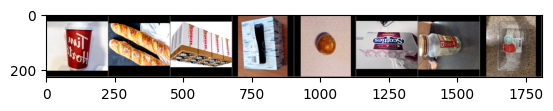

Blue  Green TTR   Black Green Blue  Blue  Blue 


In [7]:
# get some random training images
stats = (torch.tensor([0.4482, 0.4192, 0.3900]), torch.tensor([0.2918, 0.2796, 0.2709]))
dataiter = iter(dataloaders['train'])
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:8]), stats)
# print labels
print(' '.join(f'{class_names[labels[j]]:5s}' for j in range(8)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1698044..1.1004546].


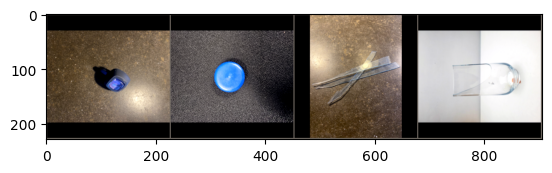

GroundTruth:  Black Black Black Black


In [8]:
dataiter = iter(dataloaders['test'])
images, labels = next(dataiter)
images = images.to(device)

# print images
imshow(torchvision.utils.make_grid(images[:4]), stats)
print('GroundTruth: ', ' '.join(f'{class_names[labels[j]]:5s}' for j in range(4)))

outputs = model(images)

In [9]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{class_names[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  Black Black Black TTR  


In [10]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in dataloaders['test']:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total} %')

Accuracy of the network on the test images: 66.08391608391608 %


In [11]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in class_names}
total_pred = {classname: 0 for classname in class_names}

# again no gradients needed
with torch.no_grad():
    for data in dataloaders['test']:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[class_names[label]] += 1
            total_pred[class_names[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Black is 44.6 %
Accuracy for class: Blue  is 78.0 %
Accuracy for class: Green is 82.2 %
Accuracy for class: TTR   is 53.3 %
